In [1]:
#standard packages
import pandas as pd
import numpy as np
import re
from pprint import pprint

#webscraping packages 
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup, SoupStrainer
import requests
import urllib.request
import functions as mf

#nlp packages
import string
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg')

#EDA packages
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns


from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors 
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
test = pd.read_csv('test.csv')
test.head()

,Unnamed: 0,_id,attorneys,case_id,case_name,case_text,court_id,court_name,decision_date,frontend_url,judges,majority_opinion,other_opinions,tokenized_majority_opinion,tokenized_other_opinions,no_stop_words_majority,no_stop_words_other
0,0,5d66e470e59ddf33befdfe06,NaN,37588,In the matter of the Complaint made against Jo...,"[{'text': 'ORDER OF PUBLIC CENSURE\nWhereas, I...",8874,Kansas Supreme Court,1970,https://cite.case.law/kan/206/335/,NaN,order of public censure whereas in a proceedin...,NaN,order of public censure whereas in a proceedin...,False,"['order', 'public', 'censure', 'proceeding', '...",False
1,1,5d66e470e59ddf33befdfe07,NaN,37656,In the matter of the Complaint made against Ro...,"[{'text': 'ORDER OF PUBLIC CENSURE\nWhereas, I...",8874,Kansas Supreme Court,1970,https://cite.case.law/kan/206/334/,NaN,order of public censure whereas in a proceedin...,NaN,order of public censure whereas in a proceedin...,False,"['order', 'public', 'censure', 'proceeding', '...",False
2,2,5d66e470e59ddf33befdfe08,NaN,1747634,State of Connecticut v. Anonymous (1971-5),"[{'text': 'Moraghan, J.\nThe defendant has mov...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/443/,NaN,moraghan j the defendant has moved to suppress...,NaN,moraghan j the defendant has moved to suppress...,False,"['moraghan', 'j', 'defendant', 'moved', 'suppr...",False
3,3,5d66e470e59ddf33befdfe09,NaN,1747661,State of Connecticut v. Anonymous (1971-3),"[{'text': ""Dearington, J.\nFollowing a trial t...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/393/,NaN,dearington j following a trial to the jury the...,NaN,dearington j following a trial to the jury the...,False,"['dearington', 'j', 'following', 'trial', 'jur...",False
4,4,5d66e470e59ddf33befdfe0a,NaN,1747680,State of Connecticut v. Anonymous (1971-7),"[{'text': 'Casale, J.\nThe defendant, after a ...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/462/,NaN,casale j the defendant after a trial to the co...,NaN,casale j the defendant after a trial to the co...,False,"['casale', 'j', 'defendant', 'trial', 'court',...",False


***Bar Plot of Word Frequency***

In [3]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [4]:
vis = mf.visualizations

In [5]:
data_words = list(vis.sent_to_words(test.majority_opinion))
data_words = [word for sublist in data_words for word in sublist]

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
list_bigrams = [word for sublist in data_words_bigrams for word in sublist]
list_trigrams = [word for sublist in data_words_trigrams for word in sublist]

In [138]:
#import data_words in here rather than majority_no_stop
# def bar_plot(list_of_words):    
#     counter = Counter(list_of_words)
#     counter_top = OrderedDict(counter.most_common(50))
#     words = counter_top.keys()
#     word_counts = counter_top.values()

#     # Plot histogram using matplotlib bar().

#     plt.figure(figsize=(10,6))
#     indexes = np.arange(len(words))
#     width = .7

#     plt.bar(indexes, word_counts, width, color = 'lightblue')
#     plt.xticks(indexes + width, words, rotation='vertical')
#     plt.title('top 50 words across all documents & frequency')
#     plt.show()


In [ ]:
vis.bar_plot(list_bigrams)

In [ ]:
vis.bar_plot(list_trigrams)

In [ ]:
majority = [i.text for i in test.tokenized_majority_opinion]

In [140]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# data_words = list(sent_to_words(majority))
# #print(data_words[:1])

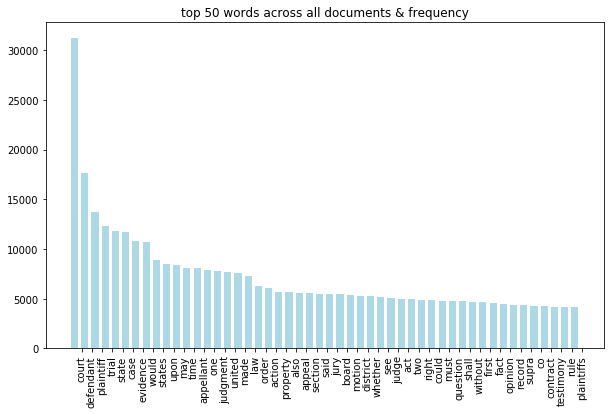

In [144]:
bar_plot(list_bigrams)

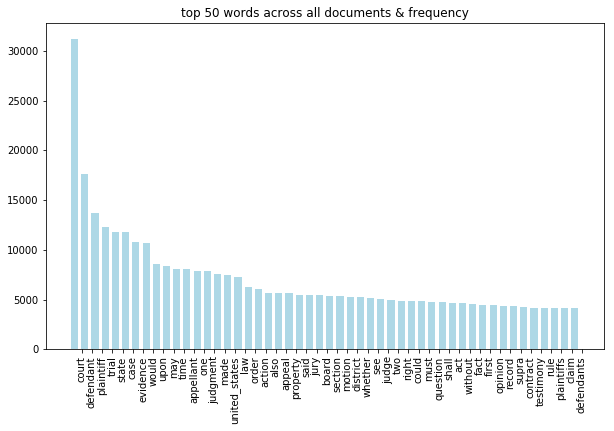

In [146]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [80]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [82]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"state" + 0.021*"united" + 0.012*"lead" + 0.011*"government" + '
  '0.010*"use" + 0.009*"case" + 0.009*"act" + 0.007*"person" + 0.007*"law" + '
  '0.007*"may"'),
 (1,
  '0.049*"court" + 0.017*"state" + 0.014*"appeal" + 0.013*"defendant" + '
  '0.013*"case" + 0.012*"order" + 0.011*"trial" + 0.010*"motion" + '
  '0.009*"judgment" + 0.008*"file"'),
 (2,
  '0.031*"tax" + 0.013*"estate" + 0.011*"employee" + 0.010*"income" + '
  '0.010*"section" + 0.009*"pay" + 0.008*"union" + 0.008*"taxpayer" + '
  '0.008*"trust" + 0.007*"death"'),
 (3,
  '0.020*"patent" + 0.017*"policy" + 0.015*"claim" + 0.012*"insurance" + '
  '0.012*"bid" + 0.011*"sale" + 0.011*"plaintiff" + 0.011*"company" + '
  '0.010*"co" + 0.009*"inc"'),
 (4,
  '0.032*"board" + 0.016*"school" + 0.014*"city" + 0.013*"district" + '
  '0.012*"section" + 0.012*"public" + 0.010*"commission" + 0.009*"provide" + '
  '0.009*"county" + 0.008*"act"'),
 (5,
  '0.119*"plaintiff" + 0.029*"damage" + 0.024*"work" + 0.021*"claim" + '
 

In [83]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.128207363838888
Coherence Score:  0.41939311975301


***Visualization of Topic Analysis Across All Documents***

In [85]:
# def vis_LDA(lda_model, corpus, id2word)
#     pyLDAvis.enable_notebook()
#     vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
#     vis

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.053296  0.178867       1        1  23.654984
6      0.009835  0.325925       2        1  22.470367
7      0.065941 -0.018208       3        1  19.287603
0     -0.259832  0.135276       4        1  12.267472
4      0.244174  0.129202       5        1   8.449196
3     -0.042598 -0.316401       6        1   5.184937
2     -0.273604 -0.159282       7        1   4.716743
5      0.309380 -0.275380       8        1   3.968699, topic_info=     Category          Freq          Term         Total  loglift  logprob
1359  Default  18035.000000     plaintiff  18035.000000  30.0000  30.0000
15    Default  33569.000000         court  33569.000000  29.0000  29.0000
62    Default  25174.000000         state  25174.000000  28.0000  28.0000
3     Default   5976.000000         board   5976.000000  27.0000  27.0000
239   Default   7990.000000         claim   7990.000000  26.0000  26.0000
188   Default   6630.000000        united   6630.000000  25.0000  25.0000
2935  Default   3229.000000           tax   3229.000000  24.0000  24.0000
115   Default  11434.000000      evidence  11434.000000  23.0000  23.0000
107   Default  21864.000000     defendant  21864.000000  22.0000  22.0000
262   Default   3325.000000        damage   3325.000000  21.0000  21.0000
2042  Default   6084.000000      contract   6084.000000  20.0000  20.0000
327   Default   5588.000000          jury   5588.000000  19.0000  19.0000
1971  Default   6145.000000      property   6145.000000  18.0000  18.0000
199   Default   7855.000000        appeal   7855.000000  17.0000  17.0000
325   Default   8422.000000      judgment   8422.000000  16.0000  16.0000
1164  Default   5621.000000      district   5621.000000  15.0000  15.0000
946   Default   3330.000000          work   3330.000000  14.0000  14.0000
1019  Default   6493.000000        action   6493.000000  13.0000  13.0000
441   Default  12638.000000         trial  12638.000000  12.0000  12.0000
879   Default   2904.000000        school   2904.000000  11.0000  11.0000
408   Default   6751.000000       section   6751.000000  10.0000  10.0000
3579  Default   2297.000000        patent   2297.000000   9.0000   9.0000
146   Default   5804.000000        motion   5804.000000   8.0000   8.0000
753   Default   4004.000000          lead   4004.000000   7.0000   7.0000
241   Default   4120.000000            co   4120.000000   6.0000   6.0000
243   Default   3973.000000       company   3973.000000   5.0000   5.0000
593   Default   3548.000000          city   3548.000000   4.0000   4.0000
44    Default   3769.000000           pay   3769.000000   3.0000   3.0000
2008  Default   4561.000000     testimony   4561.000000   2.0000   2.0000
43    Default   8036.000000         order   8036.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
2015   Topic8    312.177521          tort    333.382721   3.1610  -5.6319
192    Topic8   1116.976562      accident   1293.498901   3.0800  -4.3571
262    Topic8   2506.857666        damage   3325.098633   2.9443  -3.5487
1925   Topic8    451.470551        injure    520.362122   3.0847  -5.2630
1872   Topic8   1003.027405  compensation   1298.670898   2.9684  -4.4647
1359   Topic8  10370.547852     plaintiff  18035.218750   2.6734  -2.1288
946    Topic8   2094.088623          work   3330.541992   2.7627  -3.7286
2539   Topic8   1225.189941         award   1818.569824   2.8318  -4.2647
2377   Topic8    447.733734      railroad    573.532166   2.9791  -5.2713
1941   Topic8    738.513306       medical   1042.948120   2.8816  -4.7709
2128   Topic8    920.439331     liability   1363.421021   2.8338  -4.5507
2467   Topic8    481.646210      recovery    687.352356   2.8711  -5.1983
304    Topic8    665.178955       highway   1099.728149   2.7240  -4.8755
337    Topic8    811.084412          loss   1493.892334   2.6160  -4.6771
232    Topic8

In [86]:
vis_LDA(lda_model, corpus, id2word)

In [161]:
word_model = Word2Vec(data_words, size=100, window=5, min_count=1, workers=4)
word_vectors = word_model.wv

In [162]:
def display_pca_scatter(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.vocab]
            
    word_vectors = np.array([model[w] for w in words])
    
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='lightblue')
    #look up better way for point labeling 
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.25, y+0.25, word, rotation=45)
    plt.savefig('pca_scatter.png')

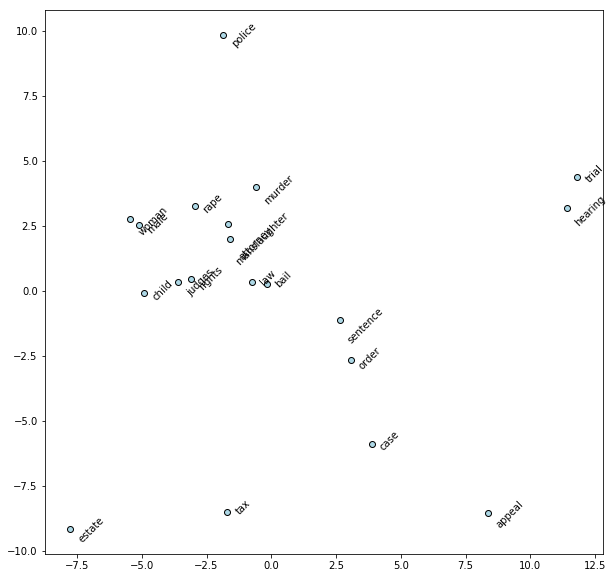

In [163]:
display_pca_scatter(word_model, words = ['order', 'murder', 'male', 'rape', 'trial',
                                        'sentence', "hearing", 'woman', 'child', 'tax', 'appeal', 
                                        'manslaughter', 'police', 'estate', 'bail', 'case', 'rights',
                                         'law', 'attorney', 'judges'], sample = 8)